In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
from scipy.spatial.distance import cdist
from datetime import date
from numpy import asarray
import seaborn as sns
import math

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
#Import Datasets

season_df = pd.read_csv('/Users/yushunli/Documents/Data Science/nfl_player_similarity/data/2013_to_2022_data.csv')
draft_df = pd.read_csv('/Users/yushunli/Documents/Data Science/nfl_player_similarity/data/1994_to_2022_draftclass.csv')

In [18]:
season_df.Player.unique()

1652

In [3]:
#Create a Position Rank columns by Season
season_df['Pos_Rank'] = season_df.groupby(['Pos', 'Season'])['Fantasy_Points'].rank(ascending = False, method = 'min')

## Calculating Similarity:
- Weight between 50% (abs. % difference of fantasy points) and 50% of euclidian distance of min-max scaled vector of tgts, recs, yards and TDs

In [4]:
def find_peers(season_df, target):
    a_df = season_df.loc[season_df.Player == target]
    a_df.reset_index(drop=True, inplace=True)
    position = a_df.Pos[0]
    min_age = a_df.Age.min()
    max_age = a_df.Age.max()
    return_df = season_df.loc[(season_df.Age >= min_age) & (season_df.Age <= max_age) & (season_df.Pos == position)] 
    #return_df = season_df.loc[(season_df.Age <= max_age) & (season_df.Pos == position)] 
    return return_df

In [5]:
def abs_difference(peer_df, target):
    peer_df = peer_df.drop_duplicates(subset = ['Player', 'Age'], keep='first')
    peer_pivot = peer_df.pivot(index = 'Player', columns = 'Age', values = 'Fantasy_Points').dropna(axis=0)
    reference_row =peer_pivot.loc[peer_pivot.index == target].iloc[0]
    peer_fantasy = round(abs(peer_pivot.sub(reference_row) / reference_row),2)
    peer_fantasy.columns = 'Age_' + peer_fantasy.columns.astype(int).astype(str)
    peer_fantasy['Avg'] = round(peer_fantasy.mean(axis = 1),2)
    compare = peer_fantasy.sort_values(by = 'Avg', ascending = True)
    fantasy_points = compare.loc[compare.index != target]
    fantasy_points = fantasy_points.sort_index()
    fantasy_points.sort_values(by = 'Avg', ascending = True, inplace=True)
    return fantasy_points

In [6]:
def euclid_rank(df, target_player, age):
    target = df.loc[df.Player == target_player]
    non = df.loc[df.Player != target_player]
    #Extract Feature Data
    ret_target = target.loc[:, target.columns.str.endswith("_Scaled")]
    ret_non = non.loc[:, target.columns.str.endswith("_Scaled")]
    #Calculate Euclidian Distance
    euclid = cdist(ret_non, ret_target,  'euclid')
    euclid = euclid.round(decimals=2)
    names = non.Player
    string = 'Age_{}'.format(str(age))
    col = [string]
    df = pd.DataFrame(data = euclid, index=names, columns = col)
    return df

In [7]:
def euclid_compare(peer_df, target):
    
    #Create list of Age ranges
    age_range = []
    
    #For Loop to Create Individual Dataframes of all unique ages
    for i in peer_df.Age.unique():
        a = str(i) 
        a = a[:-2]
        b = int(a)
        age_range.append(b)
        name = 'season_'+str(a)
        vars()[name] = peer_df.loc[peer_df.Age == i]
        #Run euclid rank
        euclid_name = 'euclid_'+str(a)
        vars()[euclid_name] = euclid_rank(df = vars()[name], target_player = target, age = a)
    
    age_range.sort()
    x = min(age_range)
    df_name = 'euclid_' +str(x)
    base_df = vars()[df_name]

    age_range_mod = age_range[1:]
    
    #Join all age dfs
    for i in age_range_mod:
        name = 'euclid_' +str(i)
        base_df = pd.merge(base_df, vars()[name], how = 'inner', on = 'Player')
    #Return Result
    else:
        base_df['Avg'] = round(base_df.mean(axis=1),2)
        return base_df.sort_values(by = 'Avg', ascending = True)

### Draft Similarity
- Find the relative draft similarity of the peers
- Calculate a Pick Score that's the average of both abs draft position and positional draft position
- Apply the Pick Score to the seasonal differences but weighted by seasons played
    - The more seasons played, the less pick score affects the similarity, and vice versa

In [8]:
def draft_position(output_df, draft_df, target):
    
    name_list = []
    
    for i in output_df.index:
        name_list.append(i)
    
    name_list.append(target)
    #Filter for output players
    peer_draft = draft_df.loc[draft_df.Player.isin(name_list)]
    
    return peer_draft

In [9]:
def draft_similarity(peer_draft, draft_df):
    #Identify the Target Player's draft position
    target_draft = peer_draft.loc[peer_draft.Player == target].iloc[0]
    
    #Calculate the Abs. Pick Difference
    peer_draft.loc[:,'Pick_Diff_Abs'] = abs(peer_draft['Pick'] - target_draft['Pick'])
    peer_draft.loc[:,'Pos_Pick_Diff_Abs'] = abs(peer_draft['Position_Pick'] - target_draft['Position_Pick'])
    peer_draft.loc[:,'Pick_Diff_Weight'] = round(1-peer_draft['Pick_Diff_Abs']/(32*7),2) #Total Picks
    
    #Calculate the average number of players drafted for each position
    agg = draft_df.groupby(by = ['Season', 'Pos'], as_index=False).count()
    agg = agg.groupby('Pos').mean()
    agg['Avg_Players_Drafted'] = round(agg['Player'],0)
    draft_avg = agg['Avg_Players_Drafted']
    draft_avg
    
    #Calculate the Positional Pick Difference
    position = peer_draft.Pos.mode()[0]
    Pos_Pick_Num = draft_avg.loc[draft_avg.index == position][0]
    peer_draft.loc[:,'Pos_Pick_Diff_Weight'] = round(1-peer_draft['Pos_Pick_Diff_Abs']/(Pos_Pick_Num),2) #Number of Players in the Position
    peer_draft.loc[:,'Pick_Score'] = round((peer_draft['Pos_Pick_Diff_Weight'] + peer_draft['Pick_Diff_Weight'])/2,2)
    peer_draft.sort_values(by = 'Pick_Score', ascending = False, inplace = True)
    peer_score = peer_draft[['Player', 'Pick_Score']]
    peer_score.set_index('Player', inplace=True)
    return peer_score.applymap(lambda x: max(0, x))

In [10]:
def draft_score_weighting(output_df, peer_score):
    #Weight the Pick Score based on the number of seasons played
    seasons_played = len(output_df.columns)-1

    #Divide Pick Score to Similarity Score - Weighted by the seasons played
    #The longer they've played, the impact the draft similarity has on the result
    peer_score_similarity = round(output_df.div(output_df.join(peer_score)['Pick_Score'], axis=0),2)
    output_df2 = round((output_df*seasons_played + peer_score_similarity)/(seasons_played+1),2)
    output_df2.sort_values(by = 'Avg', ascending = True, inplace = True)
    #output_df2.reset_index(inplace=True)
    return output_df2

In [11]:
def calculate_similarities(target, season_df, draft_df):
    #Find Peers
    peer_df = find_peers(season_df = season_df, target = target)
    
    #Calculate Abs. % Difference of each season
    fantasy_points = abs_difference(peer_df = peer_df, target = target)
    
    #Calculate Euclidean Distance
    euclid = euclid_compare(peer_df = peer_df, target = target)
    euclid = euclid.sort_index()
    euclid.sort_values(by = 'Avg', ascending = True, inplace=True)
    
    #Aggregate and Average the 2 metrics
    output_df = (fantasy_points + euclid) / 2
    output_df.sort_values(by = 'Avg', ascending=True, inplace=True)
    output_df = output_df.head(25)
    
    #Add the Draft Similarity Scores
    peer_draft = draft_position(output_df, draft_df, target)
    peer_score = draft_similarity(peer_draft, draft_df)
    final_output = draft_score_weighting(output_df, peer_score)
    final_output.dropna(subset=['Avg'], inplace=True)
    final_output = final_output.loc[final_output.Avg < 1]
    return final_output
    #return output_df

In [22]:
find_peers(season_df, 'Brandon Aiyuk')

,Player,Pos,Season,Fantasy_Points,Age,G,Cmp,Pass_Att,Pass_Yds,Pass_TD,...,Rush_Yds_Scaled,Rush_TD_Scaled,Tgt,Rec,Rec_Yds,Rec_TD,Rec_Scaled,Rec_Yds_Scaled,Rec_TD_Scaled,Pos_Rank
68,Justin Jefferson,WR,2022,301.0,23.0,17.0,0.0,0.0,0.0,0.0,...,0.023381,0.058824,184.0,128.0,1809.0,8.0,1.000000,1.000000,0.571429,1.0
98,Tyreek Hill,WR,2018,284.0,24.0,16.0,0.0,0.0,0.0,0.0,...,0.115172,0.058824,137.0,87.0,1479.0,12.0,0.693548,0.882701,0.800000,1.0
127,Justin Jefferson,WR,2021,275.0,22.0,17.0,0.0,0.0,0.0,0.0,...,0.014803,0.000000,167.0,108.0,1616.0,10.0,0.743056,0.830343,0.625000,4.0
128,DeAndre Hopkins,WR,2015,274.0,23.0,16.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,192.0,111.0,1521.0,11.0,0.814815,0.813532,0.785714,4.0
144,Josh Gordon,WR,2013,271.0,22.0,14.0,0.0,0.0,0.0,0.0,...,0.072650,0.000000,159.0,87.0,1646.0,9.0,0.767857,1.000000,0.562500,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5360,John Ross,WR,2017,-1.0,22.0,3.0,0.0,0.0,0.0,0.0,...,0.019389,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,203.0
5422,Montrell Washington,WR,2022,-5.0,23.0,15.0,0.0,0.0,0.0,0.0,...,0.026978,0.000000,9.0,4.0,2.0,0.0,0.023622,0.006597,0.000000,212.0
5426,Isaiah McKenzie,WR,2017,-7.0,22.0,11.0,0.0,0.0,0.0,0.0,...,0.013423,0.000000,13.0,4.0,29.0,0.0,0.027027,0.022742,0.000000,204.0
5427,Kalif Raymond,WR,2017,-8.0,23.0,8.0,0.0,0.0,0.0,0.0,...,0.009694,0.000000,1.0,1.0,12.0,0.0,0.000000,0.011696,0.000000,205.0


## Project Future Stats

In [12]:
def projection_stats(target, output, season_df):
    player_list = []

    #Identify the similar players
    for i in output.index:
        player_list.append(i)
        
    age = output.columns[-2]
    age = age.replace("Age_", "")
    age = float(age)
    #Look at the performances of the players in subsequent seasons
    projection_stats = season_df[season_df.Player.isin(player_list)]
    projection_stats = projection_stats.loc[projection_stats.Age > age]
    projection_stats['Age'] = projection_stats['Age'].astype(int).round()
    #Pivot the Data
    proj_points = projection_stats.pivot(index = 'Player', columns = 'Age', values = 'Fantasy_Points')
    proj_points = proj_points.reindex(output.index)
    proj_points.fillna(value = 0, inplace=True)
    proj_points['Total'] = proj_points.sum(axis = 1)
    proj_points = proj_points.loc[proj_points.Total > 0]
    proj_points.drop(columns = 'Total', inplace=True)
    return proj_points

In [13]:
def point_bucket(target, season_df):
    #Attach Rankings to Point Buckets
    position = season_df.loc[season_df.Player == target].Pos.min()
    latest = season_df.Season.max()
    latest_season_df = season_df.loc[(season_df.Season == latest) & (season_df.Pos == position)]

    point_max = int(latest_season_df.Fantasy_Points.max())
    ceiling = (math.ceil(point_max / 50) * 50)+1
    points_df = pd.DataFrame({'Fantasy_Points': range(0, ceiling, 50)})

    # Group the original dataframe by 50-point increments of points and calculate the mean rank
    latest_season_df['Points_bin'] = pd.cut(latest_season_df['Fantasy_Points'], range(0, ceiling, 50))
    avg_rank_df = latest_season_df.groupby('Points_bin')['Pos_Rank'].mean().reset_index()

    # Merge the two dataframes on the 'Points' column
    points_df['Avg_Rank'] = round(avg_rank_df['Pos_Rank'],1)
    return points_df.dropna()

In [14]:
def visualize_projections(proj_points, output):
    #Remove columns (ages) where there is insufficient data
    zero_col = None
    for col in proj_points.columns:
        if (proj_points[col] == 0).sum() / len(proj_points) > 0.5:
            zero_col = col
            break

    # Remove all columns to the right of the zero column
    if zero_col is not None:
        proj_points = proj_points.loc[:, :zero_col]

    #Repeat the weights as row numbers
    output2 = output.copy()
    output2 = output2.apply(lambda x: (1 - x)*100)
    proj_points['Weight'] = output2['Avg']
        
    weighted_proj_points = proj_points.loc[np.repeat(proj_points.index.values, proj_points['Weight'])]
    weighted_proj_points.drop(columns = 'Weight', inplace = True)
    weighted_proj_points = weighted_proj_points[weighted_proj_points != 0]
    
    #Create Box Plot
    point_map = point_bucket(target = target, season_df = season_df)
    sns.set_style("whitegrid")
    #ax = 
    sns.boxplot(data=weighted_proj_points, palette="Set2")
    ax = plt.gca()
    ax.set_ylim(point_map.Fantasy_Points.min(), point_map.Fantasy_Points.max())
    ax.set_ylabel('Fantasy Points')
    
    #Create Twin Axis for Ranking
    ax2 = ax.twinx()
    ax2.set_ylim(ax.get_ylim())
    ax2.set_yticks(ax.get_yticks())
    ax2.set_yticklabels(point_map['Avg_Rank'])
    ax2.set_ylabel('Positional Rank')


    # add median value labels
    medians = weighted_proj_points.median().values
    median_labels = [f'{val:.2f}' for val in medians]
    pos = range(len(medians))
    for tick,label in zip(pos,ax.get_xticklabels()):
        ax.text(pos[tick], medians[tick] + 2.5, median_labels[tick], 
                horizontalalignment='center', size='x-small', color='black', weight='semibold')
    
    # add title
    years = len(weighted_proj_points.columns)
    plt.title(f"Fantasy Points and Rank Projection for {target} over the next {years} seasons")

    # display the plot
    plt.show()
    proj_points.drop(columns = 'Weight', inplace = True)
    proj_points = proj_points.replace(0.0, np.nan)
    
    summary = proj_points.describe(percentiles=[0.25, 0.5, 0.75])
    return summary.loc[['max', '75%',  '50%','25%','min' ]]

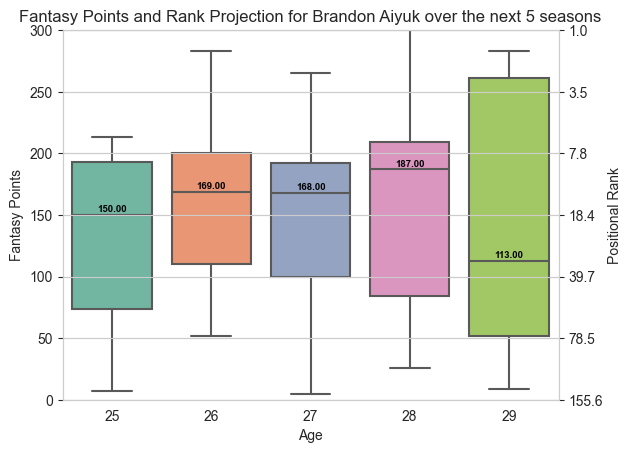

Age,25,26,27,28,29
max,213.0,283.00,265.00,303.00,283.00
75%,189.5,197.25,191.00,215.25,153.00
50%,150.0,165.50,157.00,164.00,109.00
25%,83.5,118.50,108.75,83.50,69.25
min,7.0,52.00,5.00,26.00,9.00


In [15]:
target = 'Brandon Aiyuk'
output = calculate_similarities(target = target, season_df = season_df, draft_df = draft_df)
proj_points = projection_stats(target = target, output = output, season_df = season_df)
visualize_projections(proj_points = proj_points, output = output)

- Add the name of the player in the box 
- Add existing age seasons (either as a line or as a bar, but enough to distinguish from the box and whiskerplots)

### Old Code

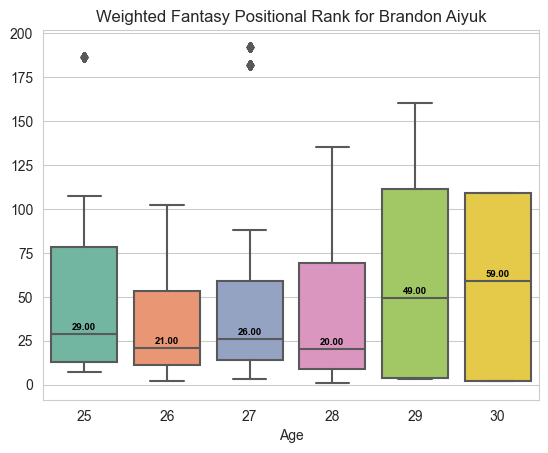

In [51]:
player_list = []

#Identify the similar players
for i in output.index:
    player_list.append(i)

age = output.columns[-2]
age = age.replace("Age_", "")
age = float(age)
#Look at the performances of the players in subsequent seasons
projection_stats = season_df[season_df.Player.isin(player_list)]
projection_stats = projection_stats.loc[projection_stats.Age > age]
projection_stats['Age'] = projection_stats['Age'].astype(int).round()

proj_rank = projection_stats.pivot(index = 'Player', columns = 'Age', values = 'Pos_Rank')
proj_rank = proj_rank.reindex(output.index)

output2 = output.copy()
output2 = output2.apply(lambda x: (1 - x)*100)
proj_rank['Weight'] = output2['Avg']

weighted_proj_rank = proj_rank.loc[np.repeat(proj_rank.index.values, proj_rank['Weight'])]
weighted_proj_rank.drop(columns = 'Weight', inplace = True)
weighted_proj_rank = weighted_proj_rank[weighted_proj_rank != 0]

sns.set_style("whitegrid")
ax = sns.boxplot(data=weighted_proj_rank, palette="Set2")

# add median value labels
medians = weighted_proj_rank.median().values
median_labels = [f'{val:.2f}' for val in medians]
pos = range(len(medians))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick] + 2.5, median_labels[tick], 
            horizontalalignment='center', size='x-small', color='black', weight='semibold')

# add title
plt.title(f"Weighted Fantasy Positional Rank for {target}")

# display the plot
plt.show()